In [1]:
import pandas as pd
import numpy as np
import requests 
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
import time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import learning_curve

In [2]:
#call asteranks api to grab data
url = "http://asterank.com/api/asterank?query=" 
response = requests.get(url + '{"price":{"ㅤ$lt":1, "ㅤ$gt":0}}&limit=1000').json()
# put that data into dataframes
df = pd.DataFrame(response)
df = df.sort_values(by = 'price' , ascending = False)
response2 = requests.get(url + '{"price":{"$gt":1}}&limit=1000').json()
df2 = pd.DataFrame(response2)


In [3]:
df

,sigma_tp,diameter,sigma_q,epoch_mjd,ad,producer,rms,H_sigma,closeness,spec_B,...,spec,q,w,moid_jup,n,sigma_ma,first_obs,n_del_obs_used,spkid,n_dop_obs_used
797,0.000054,167.791,7.607400e-08,58600.0,3.258720,Otto Matic,0.43625,,2642.423039,S,...,S,2.286373,76.303672,1.966530,0.213494,0.000011,1904-04-20,,2000532.0,
796,0.000074,148.97,5.943200e-08,58600.0,3.117824,Otto Matic,0.56529,,2640.136754,Sl,...,Sl,2.479441,5.562661,1.906030,0.210516,0.000016,1893-02-06,,2000354.0,
795,0.000059,148.128,9.015200e-08,58600.0,3.555410,Otto Matic,0.45046,,2641.611806,S,...,S,2.232245,315.136183,1.922010,0.200214,0.000012,1901-05-19,,2000471.0,
794,0.000114,139.77,9.789500e-08,58600.0,3.190289,Otto Matic,0.55520,,2639.205561,R,...,R,2.654931,345.758604,2.264850,0.197264,0.000023,1892-12-11,,2000349.0,
793,0.000123,111.251,6.904900e-08,58600.0,2.373855,Otto Matic,0.42036,,2652.158471,S,...,S,2.160638,269.731621,2.797620,0.288706,0.000036,1864-09-27,,2000040.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.658840,,7.835800e-06,58600.0,1.741019,Otto Matic,0.65906,,5423.686243,Sq,...,Sq,1.033664,160.274947,3.278320,0.603155,0.381260,2002-02-22,,3114077.0,
3,0.000015,0.33,3.568100e-09,58600.0,1.695095,Otto Matic,0.45430,,5849.051380,S(IV),...,S(IV),0.953191,162.824302,3.297030,0.646848,0.000010,1998-09-19,19.0,2025143.0,18.0
2,11.031000,,1.093200e-04,58600.0,3.996086,Otto Matic,0.43177,,3091.235120,S,...,S,0.949212,96.984016,0.963207,0.253490,2.728600,2000-02-28,,3031814.0,
1,0.020730,,7.349300e-08,58600.0,1.494963,Otto Matic,0.18908,,3456.677374,S,...,S,0.986680,13.924689,3.470550,0.713083,0.015453,2009-02-27,,3448992.0,


In [4]:
# some values were redundant and some didnt fill out for every asteroid
# These values are the ones we thought may be most useful in our initial run
new_df = df[['full_name', 'spec' , 'class' , 'ad' , 'q' , 'a' , 'e' , 'dv' ,'per' , 'price' , 'profit' , 'moid' , 'diameter', 'biop']]
new_df2 = df2[['full_name', 'spec' , 'class' , 'ad' , 'q' , 'a' , 'e' , 'dv' ,'per' , 'price' , 'profit' , 'moid' , 'diameter', 'biop']]
# new_df2
new_df

,full_name,spec,class,ad,q,a,e,dv,per,price,profit,moid,diameter
797,532 Herculina (1904 NY),S,MBA,3.258720,2.286373,2.772546,0.175353,10.733275,1686.229234,8.378840e-37,6.035861e-38,1.354400,167.791
796,354 Eleonora (1893 A),Sl,MBA,3.117824,2.479441,2.798633,0.114053,11.416972,1710.083231,5.863736e-37,3.967666e-38,1.492900,148.97
795,471 Papagena (1901 GN),S,MBA,3.555410,2.232245,2.893827,0.228619,10.449882,1798.072857,5.764868e-37,4.264148e-38,1.267260,148.128
794,349 Dembowska (1892 T),R,MBA,3.190289,2.654931,2.922610,0.091589,10.493194,1824.965628,4.843060e-37,3.564270e-38,1.657380,139.77
793,40 Harmonia,S,MBA,2.373855,2.160638,2.267247,0.047021,NaN,1246.942831,2.442248e-37,1.579404e-38,1.161590,111.251
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,(2002 DQ3),Sq,AMO,1.741019,1.033664,1.387342,0.254932,4.810807,596.861457,3.761110e-47,1.240732e-47,0.050832,
3,25143 Itokawa (1998 SF36),S(IV),APO,1.695095,0.953191,1.324143,0.280145,4.637086,556.545394,3.147010e-47,1.161512e-47,0.013095,0.33
2,(2000 DO8),S,APO,3.996086,0.949212,2.472649,0.616115,6.488635,1420.176061,9.447480e-48,1.316982e-48,0.003857,
1,(2009 DD45),S,APO,1.494963,0.986680,1.240821,0.204817,6.020556,504.850024,2.373100e-48,3.986791e-49,0.000744,


In [5]:
#we appended these two data frames so that they can be one big data frame
merge = [new_df,new_df2]
result = pd.concat(merge)
result

,full_name,spec,class,ad,q,a,e,dv,per,price,profit,moid,diameter
797,532 Herculina (1904 NY),S,MBA,3.258720,2.286373,2.772546,0.175353,10.733275,1686.229234,8.378840e-37,6.035861e-38,1.35440,167.791
796,354 Eleonora (1893 A),Sl,MBA,3.117824,2.479441,2.798633,0.114053,11.416972,1710.083231,5.863736e-37,3.967666e-38,1.49290,148.97
795,471 Papagena (1901 GN),S,MBA,3.555410,2.232245,2.893827,0.228619,10.449882,1798.072857,5.764868e-37,4.264148e-38,1.26726,148.128
794,349 Dembowska (1892 T),R,MBA,3.190289,2.654931,2.922610,0.091589,10.493194,1824.965628,4.843060e-37,3.564270e-38,1.65738,139.77
793,40 Harmonia,S,MBA,2.373855,2.160638,2.267247,0.047021,NaN,1246.942831,2.442248e-37,1.579404e-38,1.16159,111.251
...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,372 Palma (1893 AH),B,MBA,3.966001,2.334280,3.150141,0.258992,11.987880,2042.176736,4.065526e+18,2.615080e+17,1.44687,173.642
992,423 Diotima (1896 DB),C,MBA,3.176470,2.956412,3.066441,0.035882,11.224330,1961.328629,4.235026e+18,2.908848e+17,1.94249,175.859
993,702 Alauda (1910 KQ),B,MBA,3.247375,3.137278,3.192327,0.017244,12.757615,2083.336507,5.408989e+18,3.264933e+17,2.12080,190.98
994,334 Chicago (1892 L),C,OMB,3.981728,3.798870,3.890299,0.023502,11.703702,2802.676341,6.115258e+18,4.009727e+17,2.78295,198.77


In [6]:
# AU = Astronomical Units, distance from Earth to the Sun

# spec = spectral type = (classification of an asteroid based on color, make up, and its ability to reflect light)

# ad = aphelion distance (AU) = (furthest distance of the meteors orbit from the sun)

# q = perihelion (AU) = (distance of the meteors orbit from the sun)

# a = semi-major axis (AU) = (longest diameter from its obit)

# e = eccentricity = (deviation of orbit from circular form)

# dv = delta-velocity = (the change in velocity needed to needed for transferring a spacecraft from Earth to an asteroid)

# per = period => (how long for 1 revolution around the sun)

# moid = (minimum orbit intersection distance)

In [7]:
# getting rid of empty cells to make it easier to drop
m_df = result.replace('', np.nan, inplace=False)
result['diameter'] = result['diameter'].fillna(ㅤ)
result

,full_name,spec,class,ad,q,a,e,dv,per,price,profit,moid,diameter
797,532 Herculina (1904 NY),S,MBA,3.258720,2.286373,2.772546,0.175353,10.733275,1686.229234,8.378840e-37,6.035861e-38,1.35440,167.791
796,354 Eleonora (1893 A),Sl,MBA,3.117824,2.479441,2.798633,0.114053,11.416972,1710.083231,5.863736e-37,3.967666e-38,1.49290,148.97
795,471 Papagena (1901 GN),S,MBA,3.555410,2.232245,2.893827,0.228619,10.449882,1798.072857,5.764868e-37,4.264148e-38,1.26726,148.128
794,349 Dembowska (1892 T),R,MBA,3.190289,2.654931,2.922610,0.091589,10.493194,1824.965628,4.843060e-37,3.564270e-38,1.65738,139.77
793,40 Harmonia,S,MBA,2.373855,2.160638,2.267247,0.047021,NaN,1246.942831,2.442248e-37,1.579404e-38,1.16159,111.251
...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,372 Palma (1893 AH),B,MBA,3.966001,2.334280,3.150141,0.258992,11.987880,2042.176736,4.065526e+18,2.615080e+17,1.44687,173.642
992,423 Diotima (1896 DB),C,MBA,3.176470,2.956412,3.066441,0.035882,11.224330,1961.328629,4.235026e+18,2.908848e+17,1.94249,175.859
993,702 Alauda (1910 KQ),B,MBA,3.247375,3.137278,3.192327,0.017244,12.757615,2083.336507,5.408989e+18,3.264933e+17,2.12080,190.98
994,334 Chicago (1892 L),C,OMB,3.981728,3.798870,3.890299,0.023502,11.703702,2802.676341,6.115258e+18,4.009727e+17,2.78295,198.77


In [8]:
# Drop all null values
m_df = result.dropna()


m_df.to_csv('asteroids_data.csv', header = True)

In [9]:
# reading the created csv file and using it for a new dataframe
path = 'asteroids_data.csv'
nm_df = pd.read_csv(path)
nm_df

,Unnamed: 0,full_name,spec,class,ad,q,a,e,dv,per,price,profit,moid,diameter
0,797,532 Herculina (1904 NY),S,MBA,3.258720,2.286373,2.772546,0.175353,10.733275,1686.229234,8.378840e-37,6.035861e-38,1.35440,167.791
1,796,354 Eleonora (1893 A),Sl,MBA,3.117824,2.479441,2.798633,0.114053,11.416972,1710.083231,5.863736e-37,3.967666e-38,1.49290,148.970
2,795,471 Papagena (1901 GN),S,MBA,3.555410,2.232245,2.893827,0.228619,10.449882,1798.072857,5.764868e-37,4.264148e-38,1.26726,148.128
3,794,349 Dembowska (1892 T),R,MBA,3.190289,2.654931,2.922610,0.091589,10.493194,1824.965628,4.843060e-37,3.564270e-38,1.65738,139.770
4,791,674 Rachele (1908 EP),S,MBA,3.493765,2.351323,2.922544,0.195453,10.483907,1824.903811,1.577649e-37,1.162629e-38,1.38596,96.171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1532,991,372 Palma (1893 AH),B,MBA,3.966001,2.334280,3.150141,0.258992,11.987880,2042.176736,4.065526e+18,2.615080e+17,1.44687,173.642
1533,992,423 Diotima (1896 DB),C,MBA,3.176470,2.956412,3.066441,0.035882,11.224330,1961.328629,4.235026e+18,2.908848e+17,1.94249,175.859
1534,993,702 Alauda (1910 KQ),B,MBA,3.247375,3.137278,3.192327,0.017244,12.757615,2083.336507,5.408989e+18,3.264933e+17,2.12080,190.980
1535,994,334 Chicago (1892 L),C,OMB,3.981728,3.798870,3.890299,0.023502,11.703702,2802.676341,6.115258e+18,4.009727e+17,2.78295,198.770


In [10]:
# Creating a row with 0 and 1 as values to be used as our labels or output
nm_df['profitable'] = (nm_df['profit'] > 1).astype(int)
nm_df['diameter'] = nm_df['diameter'].astype(float)

In [11]:
# dropping noise and our labels from our X data frame
X = nm_df.drop(['full_name','profit','price','spec', 'class','profitable'], axis =1)
X

,Unnamed: 0,ad,q,a,e,dv,per,moid,diameter
0,797,3.258720,2.286373,2.772546,0.175353,10.733275,1686.229234,1.35440,167.791
1,796,3.117824,2.479441,2.798633,0.114053,11.416972,1710.083231,1.49290,148.970
2,795,3.555410,2.232245,2.893827,0.228619,10.449882,1798.072857,1.26726,148.128
3,794,3.190289,2.654931,2.922610,0.091589,10.493194,1824.965628,1.65738,139.770
4,791,3.493765,2.351323,2.922544,0.195453,10.483907,1824.903811,1.38596,96.171
...,...,...,...,...,...,...,...,...,...
1532,991,3.966001,2.334280,3.150141,0.258992,11.987880,2042.176736,1.44687,173.642
1533,992,3.176470,2.956412,3.066441,0.035882,11.224330,1961.328629,1.94249,175.859
1534,993,3.247375,3.137278,3.192327,0.017244,12.757615,2083.336507,2.12080,190.980
1535,994,3.981728,3.798870,3.890299,0.023502,11.703702,2802.676341,2.78295,198.770


In [12]:
# creating our y dataframe with the output
y = nm_df['profitable']

### Splitting Model between Train and Test

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train.shape

(1075, 9)

In [14]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='multinomial', max_iter=10000)

## Logisitic Regression

In [15]:
ㅤlr.fit(X_train, y_train)

NameError: name 'ᅠlr' is not defined

## Train the model

In [16]:
ㅤy_train_pred_lr = lr.predict(X_train)
ㅤnp.mean(y_train == y_train_pred_lr)

0.7413953488372093

### Validation Curve for Logisitic Regression

In [17]:
C_range = np.linspace(0.001, 100, 50)
C_range

array([1.00000000e-03, 2.04179592e+00, 4.08259184e+00, 6.12338776e+00,
       8.16418367e+00, 1.02049796e+01, 1.22457755e+01, 1.42865714e+01,
       1.63273673e+01, 1.83681633e+01, 2.04089592e+01, 2.24497551e+01,
       2.44905510e+01, 2.65313469e+01, 2.85721429e+01, 3.06129388e+01,
       3.26537347e+01, 3.46945306e+01, 3.67353265e+01, 3.87761224e+01,
       4.08169184e+01, 4.28577143e+01, 4.48985102e+01, 4.69393061e+01,
       4.89801020e+01, 5.10208980e+01, 5.30616939e+01, 5.51024898e+01,
       5.71432857e+01, 5.91840816e+01, 6.12248776e+01, 6.32656735e+01,
       6.53064694e+01, 6.73472653e+01, 6.93880612e+01, 7.14288571e+01,
       7.34696531e+01, 7.55104490e+01, 7.75512449e+01, 7.95920408e+01,
       8.16328367e+01, 8.36736327e+01, 8.57144286e+01, 8.77552245e+01,
       8.97960204e+01, 9.18368163e+01, 9.38776122e+01, 9.59184082e+01,
       9.79592041e+01, 1.00000000e+02])

In [18]:
train_scores, val_scores = validation_curve(
                estimator=LogisticRegression(max_iter=10000, multi_class='multinomial'), 
                X=X_train, 
                y=y_train, 
                param_name='C', 
                param_range=C_range,
                cv=5, n_jobs=-1)

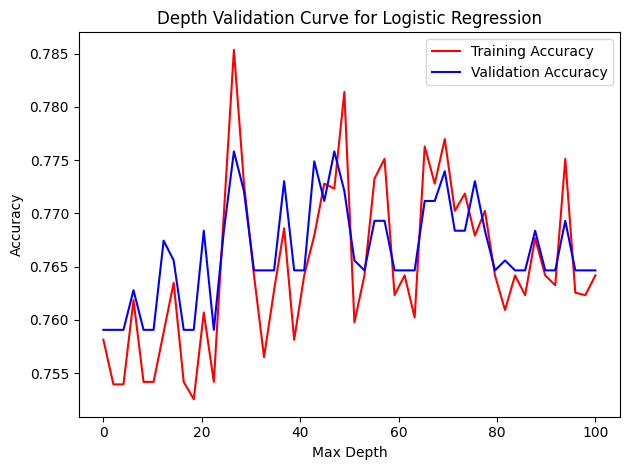

In [19]:
mean_train_scores = train_scores.mean(axis=1)
mean_val_scores = val_scores.mean(axis=1)

plt.plot(C_range,mean_train_scores, c='r', label='Training Accuracy')
plt.plot(C_range,mean_val_scores, c='b', label='Validation Accuracy')
plt.title('Depth Validation Curve for Logistic Regression')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

### Grid Search

In [20]:
C_range = np.linspace(0.1, 20, 100)
lr_grid = {'C':C_range}

In [21]:
lr_gs = GridSearchCV(estimator=LogisticRegression(max_iter=10000, multi_class='multinomial'), 
                  param_grid=lr_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=5,
                  n_jobs=-1)

In [22]:
start = time.time()
lr_gs.fit(X_train, y_train)
end = time.time()
print(f'Time Elapsed: {(end - start) * 1000} milliseconds')

Time Elapsed: 4374.037742614746 milliseconds


In [23]:
ㅤlr_gs.best_params_

{'C': 0.703030303030303}

In [24]:
ㅤlr_gs.best_score_

0.773953488372093

### Randomized Search

In [25]:
ㅤlr_dist = {'C': uniform(8, 2)}

In [26]:
ㅤlr_rs = RandomizedSearchCV(estimator=LogisticRegression(max_iter=10000, multi_class='multinomial'),
                                                    param_distributions=lr_dist, n_iter=100,
                                                    scoring='accuracy',
                                                    refit = True,
                                                    cv=5,
                                                    n_jobs=-1)

In [27]:
ㅤlr_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=10000,
                                                multi_class='multinomial'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002E570674F40>},
                   scoring='accuracy')

In [28]:
ㅤlr_rs_results = lr_rs.cv_results_
ㅤlr_rs_rank = lr_rs_results['rank_test_score']
ㅤlr_rs_sorted_idx = np.argsort(lr_rs_rank)

ㅤfor i in lr_rs_sorted_idx[:10]:
    print(lr_rs_results['params'][i], lr_rs_results['mean_test_score'][i])

{'C': 8.523853110350391} 0.7711627906976745
{'C': 8.280325957114947} 0.7711627906976745
{'C': 9.808016227593349} 0.7711627906976745
{'C': 9.751040900241492} 0.7711627906976745
{'C': 8.51738664980737} 0.7702325581395348
{'C': 8.266345157735671} 0.7693023255813953
{'C': 8.834329511892847} 0.7693023255813953
{'C': 8.261236205232183} 0.7674418604651162
{'C': 8.274771414867068} 0.7674418604651162
{'C': 8.271812191044285} 0.7674418604651162


### Learning Curve of the selected model

In [29]:
ㅤbest_lr = lr_rs.best_estimator_ if lr_rs.best_score_ > lr_gs.best_score_ else lr_gs.best_estimator_
ㅤbest_lr

LogisticRegression(C=0.703030303030303, max_iter=10000,
                   multi_class='multinomial')

In [30]:
train_sizes, train_scores, val_scores =\
                learning_curve(estimator=best_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=5,
                               n_jobs=1)

In [31]:
ㅤmean_train_scores = train_scores.mean(axis=1)
ㅤmean_val_scores = val_scores.mean(axis=1)

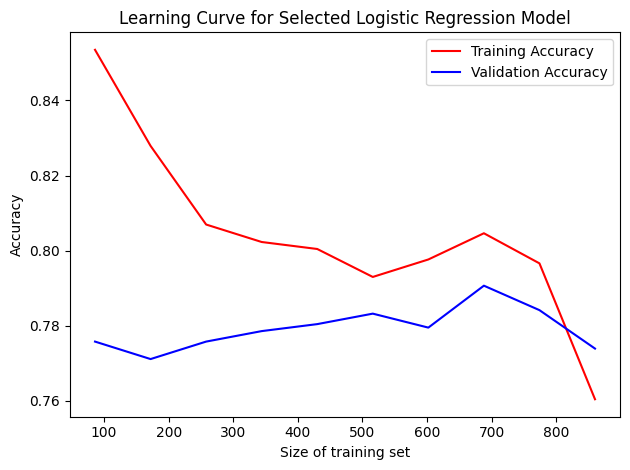

In [32]:
ㅤplt.plot(train_sizes, mean_train_scores, c='r', label='Training Accuracy')
ㅤplt.plot(train_sizes, mean_val_scores, c='b', label='Validation Accuracy')
ㅤplt.title('Learning Curve for Selected Logistic Regression Model')
ㅤplt.xlabel('Size of training set')
ㅤplt.ylabel('Accuracy')
ㅤplt.legend()
ㅤplt.tight_layout()

## Test the model

In [33]:
y_test_pred_lr = lr.predict(X_test)
np.mean(y_test == y_test_pred_lr)

0.7467532467532467

# Linear SVM

In [34]:
from sklearn.svm import SVC

## Validation Curve

In [35]:
svm_lin = SVC(kernel='linear')

### Train the model

In [36]:
svm_lin.fit(X_train,y_train)

SVC(kernel='linear')

In [37]:
y_train_pred_svm_lin = svm_lin.predict(X_train)
np.mean(y_train == y_train_pred_svm_lin)

0.7972093023255814

In [38]:
C_range = param_range = np.linspace(0.001, 100, 50)
C_range

array([1.00000000e-03, 2.04179592e+00, 4.08259184e+00, 6.12338776e+00,
       8.16418367e+00, 1.02049796e+01, 1.22457755e+01, 1.42865714e+01,
       1.63273673e+01, 1.83681633e+01, 2.04089592e+01, 2.24497551e+01,
       2.44905510e+01, 2.65313469e+01, 2.85721429e+01, 3.06129388e+01,
       3.26537347e+01, 3.46945306e+01, 3.67353265e+01, 3.87761224e+01,
       4.08169184e+01, 4.28577143e+01, 4.48985102e+01, 4.69393061e+01,
       4.89801020e+01, 5.10208980e+01, 5.30616939e+01, 5.51024898e+01,
       5.71432857e+01, 5.91840816e+01, 6.12248776e+01, 6.32656735e+01,
       6.53064694e+01, 6.73472653e+01, 6.93880612e+01, 7.14288571e+01,
       7.34696531e+01, 7.55104490e+01, 7.75512449e+01, 7.95920408e+01,
       8.16328367e+01, 8.36736327e+01, 8.57144286e+01, 8.77552245e+01,
       8.97960204e+01, 9.18368163e+01, 9.38776122e+01, 9.59184082e+01,
       9.79592041e+01, 1.00000000e+02])

In [39]:
train_scores, val_scores = validation_curve(
                estimator=SVC(max_iter=10000, kernel='linear',random_state=1), 
                X=X_train, 
                y=y_train, 
                param_name='C', 
                param_range=C_range,
                cv=5, n_jobs=-1)

In [ ]:
mean_train_scores = train_scores.mean(axis=1)
mean_val_scores = val_scores.mean(axis=1)

plt.plot(C_range,mean_train_scores, c='r', label='Training Accuracy')
plt.plot(C_range,mean_val_scores, c='b', label='Validation Accuracy')
plt.title('Depth Validation Curve for Linear SVM')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

### Grid Search

In [41]:
C_range = np.linspace(0.1, 20, 100)
svm_grid = {'C':C_range}

In [42]:
svm_gs = GridSearchCV(estimator=SVC(max_iter=10000, kernel='linear'), 
                  param_grid=svm_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=5,
                  n_jobs=-1)

In [43]:
import time
start = time.time()
svm_gs.fit(X_train, y_train)
end = time.time()
print(f'Time Elapsed: {(end - start) * 1000} milliseconds')

Time Elapsed: 7809.358596801758 milliseconds


C:\Users\marku\anaconda3\envs\ai\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [44]:
svm_gs.best_params_

{'C': 0.502020202020202}

In [45]:
svm_gs.best_score_

0.5599999999999999

In [46]:
svm_gs_results = svm_gs.cv_results_
svm_gs_rank = svm_gs_results['rank_test_score']
svm_gs_sorted_idx = np.argsort(svm_gs_rank)

for i in svm_gs_sorted_idx[:10]:
    print(svm_gs_results['params'][i], svm_gs_results['mean_test_score'][i])

{'C': 0.502020202020202} 0.5599999999999999
{'C': 1.3060606060606061} 0.5497674418604651
{'C': 4.924242424242424} 0.5404651162790698
{'C': 0.1} 0.5367441860465116
{'C': 2.311111111111111} 0.533953488372093
{'C': 3.7181818181818183} 0.5330232558139535
{'C': 0.703030303030303} 0.532093023255814
{'C': 3.1151515151515152} 0.5293023255813953
{'C': 3.316161616161616} 0.5246511627906977
{'C': 2.512121212121212} 0.5209302325581395


### Randomized Search

In [47]:
svm_dist = {'C': uniform(8, 2)}

In [48]:
svm_rs = RandomizedSearchCV(estimator=SVC(max_iter=10000),
                                                    param_distributions=svm_dist, n_iter=100,
                                                    scoring='accuracy',
                                                    refit = True,
                                                    cv=5,
                                                    n_jobs=-1)

In [49]:
import time
start = time.time()
svm_rs.fit(X_train, y_train)
end = time.time()
print(f'Time Elapsed: {(end - start) * 1000} milliseconds')

Time Elapsed: 8390.66743850708 milliseconds


In [50]:
svm_rs_results = svm_rs.cv_results_
svm_rs_rank = svm_rs_results['rank_test_score']
svm_rs_sorted_idx = np.argsort(svm_rs_rank)

for i in svm_rs_sorted_idx[:10]:
    print(svm_rs_results['params'][i], svm_rs_results['mean_test_score'][i])

{'C': 8.093364617327216} 0.5888372093023255
{'C': 8.263987490627413} 0.587906976744186
{'C': 8.340034534038088} 0.587906976744186
{'C': 9.781059395778062} 0.587906976744186
{'C': 8.413088914930675} 0.587906976744186
{'C': 8.240057590935116} 0.587906976744186
{'C': 8.332499502503742} 0.587906976744186
{'C': 8.259161142996799} 0.587906976744186
{'C': 8.206997416411616} 0.587906976744186
{'C': 8.33327829755749} 0.587906976744186


### Learning Curve

In [51]:
best_svm = svm_rs.best_estimator_ if svm_rs.best_score_ > svm_gs.best_score_ else svm_gs.best_estimator_
best_svm

SVC(C=8.093364617327216, max_iter=10000)

In [52]:
train_sizes, train_scores, val_scores =\
                learning_curve(estimator=best_svm,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=5,
                               n_jobs=1)

In [53]:
mean_train_scores = train_scores.mean(axis=1)
mean_val_scores = val_scores.mean(axis=1)

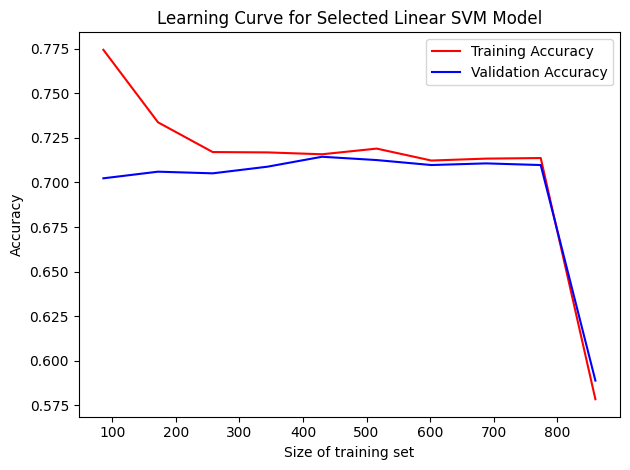

In [54]:
plt.plot(train_sizes, mean_train_scores, c='r', label='Training Accuracy')
plt.plot(train_sizes, mean_val_scores, c='b', label='Validation Accuracy')
plt.title('Learning Curve for Selected Linear SVM Model')
plt.xlabel('Size of training set')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

### Test

In [55]:
y_test_pred_svm = best_svm.predict(X_test)
np.mean(y_test == y_test_pred_svm)

0.5606060606060606

# Gaussian SVM

In [56]:
svm_gauss = SVC(kernel='rbf', gamma=0.1)

### Train the model

In [57]:
svm_gauss.fit(X_train,y_train)

SVC(gamma=0.1)

In [58]:
y_pred_svm_gauss = svm_gauss.predict(X_train)
np.mean(y_train == y_pred_svm_gauss)

1.0

## Validation Curve

In [59]:
g_range = np.linspace(0.0001, 1, 100)
g_range

array([1.000e-04, 1.020e-02, 2.030e-02, 3.040e-02, 4.050e-02, 5.060e-02,
       6.070e-02, 7.080e-02, 8.090e-02, 9.100e-02, 1.011e-01, 1.112e-01,
       1.213e-01, 1.314e-01, 1.415e-01, 1.516e-01, 1.617e-01, 1.718e-01,
       1.819e-01, 1.920e-01, 2.021e-01, 2.122e-01, 2.223e-01, 2.324e-01,
       2.425e-01, 2.526e-01, 2.627e-01, 2.728e-01, 2.829e-01, 2.930e-01,
       3.031e-01, 3.132e-01, 3.233e-01, 3.334e-01, 3.435e-01, 3.536e-01,
       3.637e-01, 3.738e-01, 3.839e-01, 3.940e-01, 4.041e-01, 4.142e-01,
       4.243e-01, 4.344e-01, 4.445e-01, 4.546e-01, 4.647e-01, 4.748e-01,
       4.849e-01, 4.950e-01, 5.051e-01, 5.152e-01, 5.253e-01, 5.354e-01,
       5.455e-01, 5.556e-01, 5.657e-01, 5.758e-01, 5.859e-01, 5.960e-01,
       6.061e-01, 6.162e-01, 6.263e-01, 6.364e-01, 6.465e-01, 6.566e-01,
       6.667e-01, 6.768e-01, 6.869e-01, 6.970e-01, 7.071e-01, 7.172e-01,
       7.273e-01, 7.374e-01, 7.475e-01, 7.576e-01, 7.677e-01, 7.778e-01,
       7.879e-01, 7.980e-01, 8.081e-01, 8.182e-01, 

In [60]:
train_scores, val_scores = validation_curve(
                estimator=SVC(max_iter=10000), 
                X=X_train, 
                y=y_train, 
                param_name='gamma', 
                param_range=g_range,
                cv=5, n_jobs=-1)

In [ ]:
mean_train_scores = train_scores.mean(axis=1)
mean_val_scores = val_scores.mean(axis=1)

plt.plot(C_range,mean_train_scores, c='r', label='Training Accuracy')
plt.plot(C_range,mean_val_scores, c='b', label='Validation Accuracy')
plt.title('Depth Validation Curve for Gaussian SVM')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

### Grid Search

In [62]:
g_range = np.linspace(0.001, 1, 50)
gamma = np.logspace(-9,3,13)
g_svm_grid = {'C':g_range, 'gamma':gamma}
# (0.1, 1, 1)

In [63]:
g_svm_gs = GridSearchCV(estimator=SVC(max_iter=10000), 
                  param_grid=g_svm_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=5,
                  n_jobs=-1)

In [64]:
import time
start = time.time()
g_svm_gs.fit(X_train, y_train)
end = time.time()
print(f'Time Elapsed: {(end - start) * 1000} milliseconds')

Time Elapsed: 83940.04678726196 milliseconds


In [65]:
g_svm_gs.best_params_

{'C': 1.0, 'gamma': 0.0001}

In [66]:
g_svm_gs.best_score_

0.7376744186046512

In [67]:
g_svm_gs_results = g_svm_gs.cv_results_
g_svm_gs_rank = g_svm_gs_results['rank_test_score']
g_svm_gs_sorted_idx = np.argsort(g_svm_gs_rank)

for i in g_svm_gs_sorted_idx[:10]:
    print(g_svm_gs_results['params'][i], g_svm_gs_results['mean_test_score'][i])

{'C': 1.0, 'gamma': 0.0001} 0.7376744186046512
{'C': 0.9796122448979593, 'gamma': 0.0001} 0.7367441860465116
{'C': 0.9388367346938776, 'gamma': 0.0001} 0.7367441860465116
{'C': 0.9592244897959185, 'gamma': 0.0001} 0.7367441860465116
{'C': 0.9184489795918368, 'gamma': 0.0001} 0.7367441860465116
{'C': 0.898061224489796, 'gamma': 0.0001} 0.7358139534883722
{'C': 0.8776734693877551, 'gamma': 0.0001} 0.7339534883720931
{'C': 0.8572857142857143, 'gamma': 0.0001} 0.7339534883720931
{'C': 0.8368979591836735, 'gamma': 0.0001} 0.7330232558139536
{'C': 0.775734693877551, 'gamma': 0.0001} 0.7330232558139536


### Randomized Search

In [68]:
g_svm_dist = {'C': uniform(8, 2), 'gamma':uniform(0.001, 1)}

In [69]:
g_svm_rs = RandomizedSearchCV(estimator=SVC(max_iter=10000),
                                                    param_distributions=g_svm_dist, n_iter=100,
                                                    scoring='accuracy',
                                                    refit = True,
                                                    cv=5,
                                                    n_jobs=-1)

In [70]:
import time
start = time.time()
g_svm_rs.fit(X_train, y_train)
end = time.time()
print(f'Time Elapsed: {(end - start) * 1000} milliseconds')

Time Elapsed: 19848.8552570343 milliseconds


In [71]:
g_svm_rs_results = g_svm_rs.cv_results_
g_svm_rs_rank = g_svm_rs_results['rank_test_score']
g_svm_rs_sorted_idx = np.argsort(g_svm_rs_rank)

for i in g_svm_rs_sorted_idx[:10]:
    print(g_svm_rs_results['params'][i], g_svm_rs_results['mean_test_score'][i])

{'C': 8.89984802521916, 'gamma': 0.009423939890841893} 0.6493023255813954
{'C': 8.048169616452723, 'gamma': 0.014647512352453318} 0.6269767441860464
{'C': 9.077506944226316, 'gamma': 0.017134370949655753} 0.6158139534883721
{'C': 9.20954046908884, 'gamma': 0.05630627087649265} 0.5711627906976744
{'C': 8.810033713327039, 'gamma': 0.054177825395050894} 0.5702325581395349
{'C': 8.803093721263386, 'gamma': 0.0595254752880896} 0.5674418604651162
{'C': 9.974266549749606, 'gamma': 0.0758866353189821} 0.5618604651162791
{'C': 9.241987488902629, 'gamma': 0.08643663722744621} 0.5581395348837209
{'C': 9.437551757913171, 'gamma': 0.09079751060907815} 0.5581395348837208
{'C': 8.435240180751924, 'gamma': 0.11210318303647915} 0.5562790697674418


### Learning Curve

In [72]:
best_g_svm = g_svm_rs.best_estimator_ if g_svm_rs.best_score_ > g_svm_gs.best_score_ else g_svm_gs.best_estimator_
best_g_svm

SVC(gamma=0.0001, max_iter=10000)

In [73]:
train_sizes, train_scores, val_scores =\
                learning_curve(estimator=best_g_svm,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=5,
                               n_jobs=1)

In [74]:
mean_train_scores = train_scores.mean(axis=1)
mean_val_scores = val_scores.mean(axis=1)

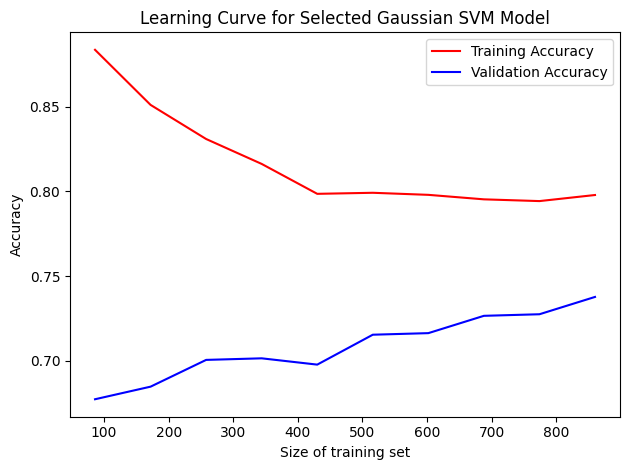

In [75]:
plt.plot(train_sizes, mean_train_scores, c='r', label='Training Accuracy')
plt.plot(train_sizes, mean_val_scores, c='b', label='Validation Accuracy')
plt.title('Learning Curve for Selected Gaussian SVM Model')
plt.xlabel('Size of training set')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

### Test

In [76]:
y_test_pred_g_svm = best_g_svm.predict(X_test)
np.mean(y_test == y_test_pred_g_svm)

0.7770562770562771

# K Nearest Neighbors

In [77]:
from sklearn.neighbors import KNeighborsClassifier

In [78]:
knn = KNeighborsClassifier()

### Train the model

In [79]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [80]:
y_pred_knn = knn.predict(X_train)
np.mean(y_train == y_pred_knn)

0.8167441860465117

## Validation Curve

In [81]:
n_range = range(5,31)
n_range

range(5, 31)

In [82]:
train_scores, val_scores = validation_curve(
                estimator=KNeighborsClassifier(), 
                X=X_train, 
                y=y_train, 
                param_name='n_neighbors', 
                param_range=n_range,
                cv=5, n_jobs=-1)

In [83]:
mean_train_scores = train_scores.mean(axis=1)
mean_val_scores = val_scores.mean(axis=1)

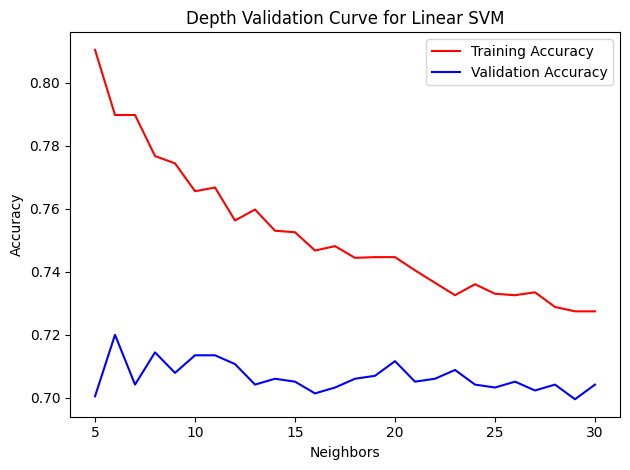

In [84]:
plt.plot(n_range,mean_train_scores, c='r', label='Training Accuracy')
plt.plot(n_range,mean_val_scores, c='b', label='Validation Accuracy')
plt.title('Depth Validation Curve for Linear SVM')
plt.ylabel('Accuracy')
plt.xlabel('Neighbors')
plt.legend()
plt.tight_layout()

### Grid Search

In [85]:
knn_grid = {'n_neighbors':n_range, 'weights': ('uniform', 'distance')}

In [86]:
knn_gs = GridSearchCV(estimator=KNeighborsClassifier(), 
                  param_grid=knn_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=5,
                  n_jobs=-1)

In [87]:
import time
start = time.time()
knn_gs.fit(X_train, y_train)
end = time.time()
print(f'Time Elapsed: {(end - start) * 1000} milliseconds')

Time Elapsed: 742.0790195465088 milliseconds


In [88]:
knn_gs.best_params_

{'n_neighbors': 19, 'weights': 'distance'}

In [89]:
knn_gs.best_score_

0.7283720930232558

In [90]:
knn_gs_results = knn_gs.cv_results_
knn_gs_rank = knn_gs_results['rank_test_score']
knn_gs_sorted_idx = np.argsort(knn_gs_rank)

for i in knn_gs_sorted_idx[:10]:
    print(knn_gs_results['params'][i], knn_gs_results['mean_test_score'][i])

{'n_neighbors': 19, 'weights': 'distance'} 0.7283720930232558
{'n_neighbors': 27, 'weights': 'distance'} 0.7255813953488373
{'n_neighbors': 25, 'weights': 'distance'} 0.7255813953488373
{'n_neighbors': 18, 'weights': 'distance'} 0.7255813953488371
{'n_neighbors': 26, 'weights': 'distance'} 0.7246511627906976
{'n_neighbors': 10, 'weights': 'distance'} 0.7237209302325581
{'n_neighbors': 8, 'weights': 'distance'} 0.7237209302325581
{'n_neighbors': 14, 'weights': 'distance'} 0.723720930232558
{'n_neighbors': 13, 'weights': 'distance'} 0.7227906976744185
{'n_neighbors': 17, 'weights': 'distance'} 0.7227906976744185


### Randomized Search

In [91]:
import random
weights = ['uniform', 'distance']
knn_dist = {'n_neighbors':n_range, 'weights':weights }

In [92]:
knn_rs = RandomizedSearchCV(estimator=KNeighborsClassifier(),
                            param_distributions=knn_dist, n_iter=100,
                            scoring='accuracy',
                            refit = True,
                            cv=5,
                            n_jobs=-1)

In [93]:
import time
start = time.time()
knn_rs.fit(X_train, y_train)
end = time.time()
print(f'Time Elapsed: {(end - start) * 1000} milliseconds')

C:\Users\marku\anaconda3\envs\ai\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 52 is smaller than n_iter=100. Running 52 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Time Elapsed: 802.2260665893555 milliseconds


In [94]:
knn_rs_results = knn_rs.cv_results_
knn_rs_rank = knn_rs_results['rank_test_score']
knn_rs_sorted_idx = np.argsort(knn_rs_rank)

for i in knn_rs_sorted_idx[:10]:
    print(knn_rs_results['params'][i], knn_rs_results['mean_test_score'][i])

{'weights': 'distance', 'n_neighbors': 19} 0.7283720930232558
{'weights': 'distance', 'n_neighbors': 27} 0.7255813953488373
{'weights': 'distance', 'n_neighbors': 25} 0.7255813953488373
{'weights': 'distance', 'n_neighbors': 18} 0.7255813953488371
{'weights': 'distance', 'n_neighbors': 26} 0.7246511627906976
{'weights': 'distance', 'n_neighbors': 10} 0.7237209302325581
{'weights': 'distance', 'n_neighbors': 8} 0.7237209302325581
{'weights': 'distance', 'n_neighbors': 14} 0.723720930232558
{'weights': 'distance', 'n_neighbors': 13} 0.7227906976744185
{'weights': 'distance', 'n_neighbors': 17} 0.7227906976744185


### Learning Curve

In [95]:
best_knn = knn_rs.best_estimator_ if knn_rs.best_score_ > knn_gs.best_score_ else knn_gs.best_estimator_
best_knn

KNeighborsClassifier(n_neighbors=19, weights='distance')

In [96]:
train_sizes, train_scores, val_scores =\
                learning_curve(estimator=best_knn,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=5,
                               n_jobs=1)

In [97]:
mean_train_scores = train_scores.mean(axis=1)
mean_val_scores = val_scores.mean(axis=1)

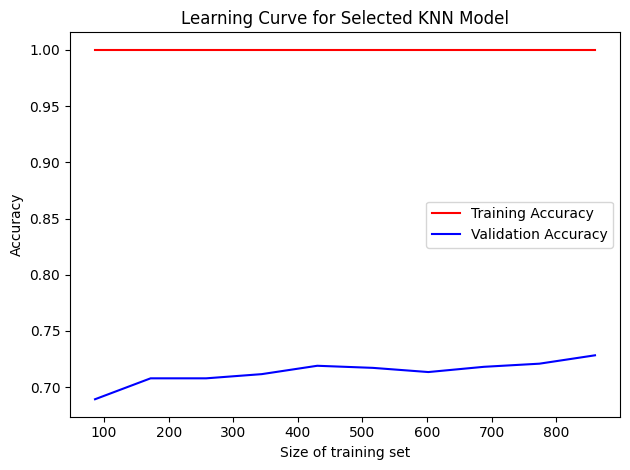

In [98]:
plt.plot(train_sizes, mean_train_scores, c='r', label='Training Accuracy')
plt.plot(train_sizes, mean_val_scores, c='b', label='Validation Accuracy')
plt.title('Learning Curve for Selected KNN Model')
plt.xlabel('Size of training set')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

### Test

In [99]:
y_test_pred_knn = best_knn.predict(X_test)
np.mean(y_test == y_test_pred_knn)

0.7662337662337663

## Random Forest

In [100]:
from sklearn.ensemble import RandomForestClassifier

In [101]:
rf = RandomForestClassifier(criterion='gini',n_estimators=25,n_jobs=2)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=25, n_jobs=2)

### Train the model

In [102]:
y_train_pred_rf = rf.predict(X_train)
np.mean(y_train == y_train_pred_rf)

1.0

## Depth Validation Curve

In [103]:
depth_range = np.arange(5, 31)

In [104]:
train_scores, val_scores = validation_curve(
                estimator=RandomForestClassifier(), 
                X=X_train, 
                y=y_train, 
                param_name='max_depth', 
                param_range=depth_range,
                cv=5, n_jobs=-1)

In [105]:
mean_train_scores = train_scores.mean(axis=1)
mean_val_scores = val_scores.mean(axis=1)

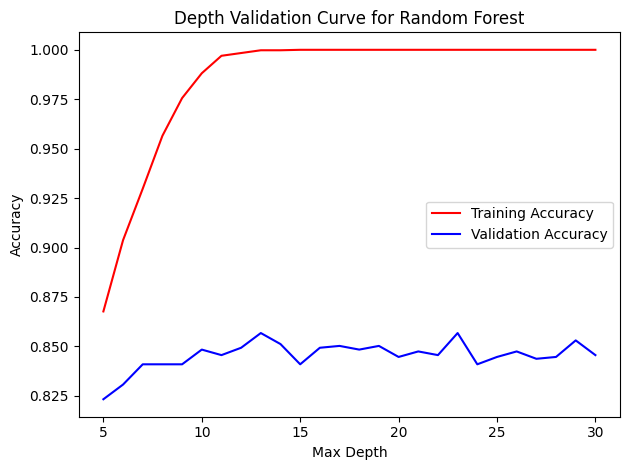

In [106]:
plt.plot(depth_range,mean_train_scores, c='r', label='Training Accuracy')
plt.plot(depth_range,mean_val_scores, c='b', label='Validation Accuracy')
plt.title('Depth Validation Curve for Random Forest')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

## n_estimators Validation Curves

In [107]:
n_trees_range = np.arange(10,210,10)

In [108]:
train_scores, val_scores = validation_curve(
                estimator=RandomForestClassifier(), 
                X=X_train, 
                y=y_train, 
                param_name='n_estimators', 
                param_range=n_trees_range,
                cv=5, n_jobs=-1)

In [109]:
mean_train_scores = train_scores.mean(axis=1)
mean_val_scores = val_scores.mean(axis=1)

In [ ]:
plt.plot(n_trees_range,mean_train_scores, c='r', label='Training Accuracy')
plt.plot(n_trees_range,mean_val_scores, c='b', label='Validation Accuracy')
plt.title('n_estimators Validation Curve for Random Forest')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

### Grid Search

In [111]:
depth_range = np.arange(5, 31)
n_trees_range = np.arange(30,200,10)
rf_grid = {'max_depth': depth_range, 'n_estimators':n_trees_range}
rf_grid

{'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30]),
 'n_estimators': array([ 30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150,
        160, 170, 180, 190])}

In [112]:
rf_gs = GridSearchCV(estimator=RandomForestClassifier(), 
                  param_grid=rf_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=5,
                  n_jobs=-1)

In [113]:
ㅤstart = time.time()
ㅤrf_gs.fit(X_train, y_train)
ㅤend = time.time()
ㅤprint(f'Time Elapsed: {(end - start) * 1000} milliseconds')

Time Elapsed: 190512.75205612183 milliseconds


In [114]:
ㅤrf_gs.best_params_

{'max_depth': 19, 'n_estimators': 160}

In [115]:
ㅤrf_gs.best_score_

0.8548837209302327

In [116]:
ㅤbest_rf = rf_gs.best_estimator_
ㅤbest_rf

RandomForestClassifier(max_depth=19, n_estimators=160)

### Randomized Search

In [117]:
ㅤrf_dist = {'n_estimators': np.arange(1, 101)}

In [118]:
ㅤrf_rs = RandomizedSearchCV(estimator=RandomForestClassifier(criterion='gini',n_estimators=25,n_jobs=2),
                                                    param_distributions=rf_dist, n_iter=100,
                                                    scoring='accuracy',
                                                    refit = True,
                                                    cv=5,
                                                    n_jobs=-1)

In [119]:
ㅤstart = time.time()
ㅤrf_rs.fit(X_train, y_train)
ㅤend = time.time()
ㅤprint(f'Time Elapsed: {(end - start) * 1000} milliseconds')

Time Elapsed: 22447.037935256958 milliseconds


In [120]:
ㅤrf_rs_results = rf_rs.cv_results_
ㅤrf_rs_rank = rf_rs_results['rank_test_score']
ㅤrf_rs_sorted_idx = np.argsort(rf_rs_rank)

ㅤfor i in rf_rs_sorted_idx[:10]:
    print(rf_rs_results['params'][i], rf_rs_results['mean_test_score'][i])

{'n_estimators': 45} 0.8520930232558139
{'n_estimators': 66} 0.8520930232558139
{'n_estimators': 68} 0.8502325581395349
{'n_estimators': 90} 0.8502325581395349
{'n_estimators': 58} 0.8502325581395347
{'n_estimators': 99} 0.8493023255813954
{'n_estimators': 88} 0.8493023255813954
{'n_estimators': 78} 0.8493023255813954
{'n_estimators': 57} 0.8493023255813952
{'n_estimators': 86} 0.8483720930232559


### Learning Curve

In [121]:
ㅤbest_rf = rf_rs.best_estimator_ if rf_rs.best_score_ > rf_gs.best_score_ else rf_gs.best_estimator_
ㅤbest_rf

RandomForestClassifier(max_depth=19, n_estimators=160)

In [122]:
train_sizes, train_scores, val_scores =\
                learning_curve(estimator=best_rf,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=5,
                               n_jobs=1)

In [123]:
mean_train_scores = train_scores.mean(axis=1)
mean_val_scores = val_scores.mean(axis=1)

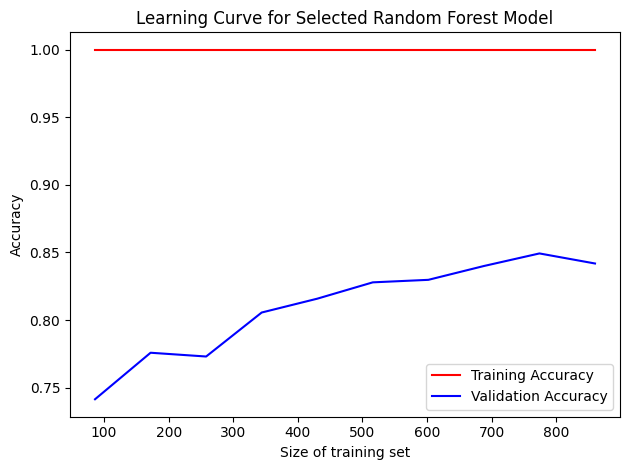

In [124]:
plt.plot(train_sizes, mean_train_scores, c='r', label='Training Accuracy')
plt.plot(train_sizes, mean_val_scores, c='b', label='Validation Accuracy')
plt.title('Learning Curve for Selected Random Forest Model')
plt.xlabel('Size of training set')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

### Test the selected model

In [125]:
y_test_pred_rf = best_rf.predict(X_test)
np.mean(y_test = = y_test_pred_rf)

0.8722943722943723

## Feature importance

In [127]:
# Training a Random Forest Classifier model and printing the score
rf = RandomForestClassifier(random_state=1, n_estimators=100).fit(X_train, y_train)

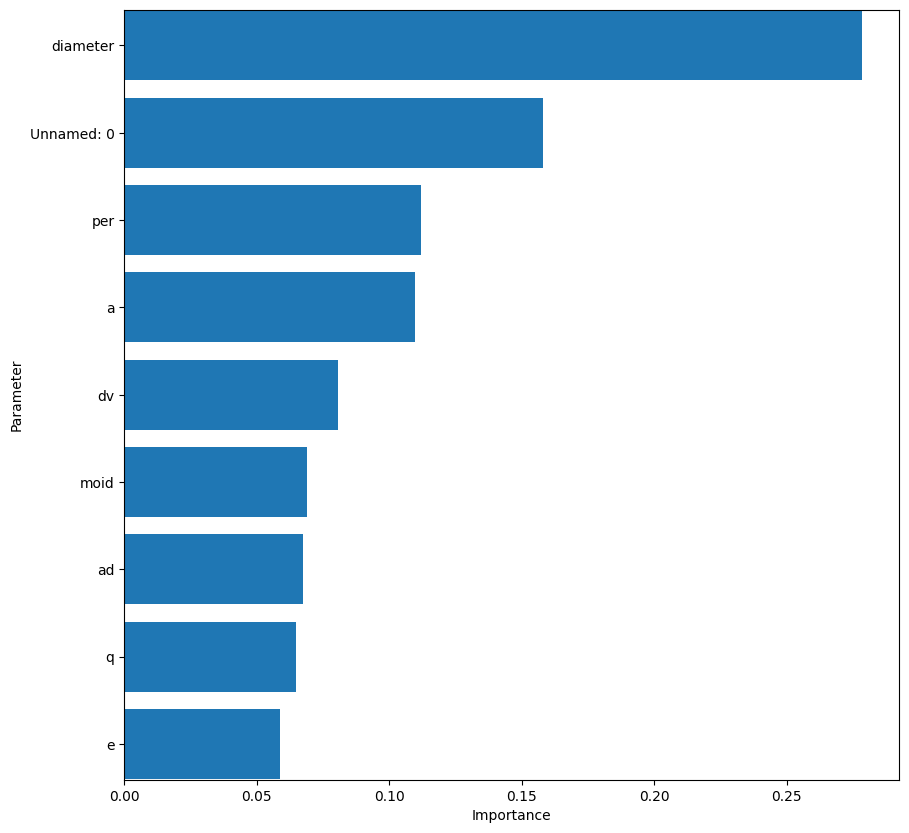

In [129]:
# Figuring out which parameters were the most important so we can make an improved model
feature_importances = rf.feature_importances_
features = sorted(zip(X.columns, rf.feature_importances _), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

# Creating the graph 
fig, ax = plt.subplots()

fig.set_size_inches(10,10)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)
plt.xlabel('Importance')
plt.ylabel('Parameter')
plt.show()